In [0]:
 %tensorflow_version 1.x
from keras import Model
import keras.layers as layers
from keras.datasets import cifar100 
from matplotlib import pyplot
import keras
import numpy as np
import os
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# num of classes in cifar dataset
num_classes = 100

def bottleneck_residual_block(n_filters, input_x):
  """ Create a Bottle neck Residual Block of Convolutions
      n_filters: number of filters
      input_x : input into the block
  """
  shortcut = input_x
  input_x = layers.Conv2D(n_filters, (1, 1), strides=(1, 1))(input_x)
  input_x = layers.BatchNormalization()(input_x)
  input_x = layers.ReLU()(input_x)
  input_x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding="same")(input_x)
  input_x = layers.BatchNormalization()(input_x)
  input_x = layers.ReLU()(input_x)
  input_x = layers.Conv2D(n_filters * 4, (1, 1), strides=(1, 1))(input_x)
  input_x = layers.BatchNormalization()(input_x)
  input_x = layers.add([shortcut, input_x])
  input_x = layers.ReLU()(input_x)
  return input_x



def conv_block(n_filters, input_x,strides=(2,2)):
  """ Create Block of Convolutions with feature pooling
      Increase the number of filters by 4X
      n_filters: number of filters
      input_x : input into the block
  """
  # construct the identity link
  # increase filters by 4X to match shape when added to output of block
  shortcut = layers.Conv2D(4 * n_filters, (1, 1), strides=strides)(input_x)
  shortcut = layers.BatchNormalization()(shortcut)
  # construct the 1x1, 3x3, 1x1 convolution block
  # feature pooling when strides=(2, 2)
  input_x = layers.Conv2D(n_filters, (1, 1), strides=strides)(input_x)
  input_x = layers.BatchNormalization()(input_x)
  input_x = layers.ReLU()(input_x)
  input_x = layers.Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(input_x)
  input_x = layers.BatchNormalization()(input_x)
  input_x = layers.ReLU()(input_x)
  # increase the number of filters by 4X
  input_x = layers.Conv2D(4 * n_filters, (1, 1), strides=(1, 1))(input_x)
  input_x = layers.BatchNormalization()(input_x)
  # add the identity link to the output of the convolution block
  input_x = layers.add([input_x, shortcut])
  input_x = layers.ReLU()(input_x)
  return input_x


Using TensorFlow backend.


In [0]:
def build_arch(input_shape):
  # The input tensor
  inputs = layers.Input(input_shape)
  # First Convolutional layer, where pooled feature maps will be reduced by 75%
  # First Convolutional layer, where pooled feature maps will be reduced by 75%
  x = layers.ZeroPadding2D(padding=(3, 3))(inputs)
  x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.ZeroPadding2D(padding=(1, 1))(x)
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2))(x)
  x = conv_block(64, x, strides=(1,1))

  # First Residual Block Group of 64 filters
  for _ in range(2):
    x = bottleneck_residual_block(64, x)
  # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
  x = conv_block(128, x)
  # Second Residual Block Group of 128 filters
  for _ in range(3):
    x = bottleneck_residual_block(128, x)
  # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
  x = conv_block(256, x)
  # Third Residual Block Group of 256 filters
  for _ in range(5):
    x = bottleneck_residual_block(256, x)
  # Double the size of filters and reduce feature maps by 75% (strides=2, 2) to fit the next Residual Group
  x = conv_block(512, x)
  # Fourth Residual Block Group of 512 filters
  for _ in range(2):
    x = bottleneck_residual_block(512, x)
  # Now Pool at the end of all the convolutional residual blocks
  x = layers.GlobalAveragePooling2D()(x)
  # Final Dense Outputting Layer for 1000 outputs
  outputs = layers.Dense(100, activation='softmax')(x)
  model = Model(inputs, outputs)
  return model

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


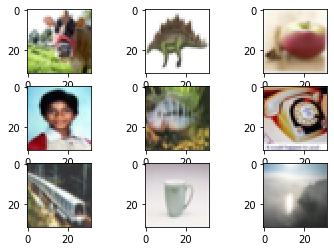

In [0]:
# Dataset of 50,000 32x32 color training images, labeled over 100 categories, and 10,000 test images.
(trainX, trainY), (testX, testY) = cifar100.load_data(label_mode='fine')

#show the shapes
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [0]:
#input Image dimensions
input_shape = trainX.shape[1:]

#normalizing the training and test data
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255

#subtracting mean from pixels
trainX_mean = np.mean(trainX, axis=0)
trainX -= trainX_mean
testX -= trainX_mean

# Convert class vectors to binary class matrices.
trainY = keras.utils.to_categorical(trainY, num_classes)
testY = keras.utils.to_categorical(testY, num_classes)


print ("number of training examples = " + str(trainX.shape[0]))
print ("number of test examples = " + str(testX.shape[0]))
print ("X_train shape: " + str(trainX.shape))
print ("Y_train shape: " + str(trainY.shape))
print ("X_test shape: " + str(testX.shape))
print ("Y_test shape: " + str(testY.shape))

model = build_arch(input_shape)
model.summary()

number of training examples = 50000
number of test examples = 10000
X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 100)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 100)












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   9472        zero_padding2d_1[0][0]           
________________________________________________________________________________________

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar100.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

# log_directory = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tb_callback = keras.callbacks.TensorBoard(log_dir=log_directory)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=30, mode='auto', baseline=None, restore_best_weights=True)


lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [early_stopping,checkpoint, lr_reducer, lr_scheduler]

model.compile(optimizer=Adam(lr=lr_schedule(0)), loss='categorical_crossentropy', metrics=['accuracy'])



datagen = ImageDataGenerator(
        zca_epsilon=1e-06,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest',
        horizontal_flip=True
        )

datagen.fit(trainX)

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(datagen.flow(trainX, trainY, batch_size=32),
                    validation_data=(testX,testY),
                    epochs=200, verbose=1, workers=4,
                    callbacks=callbacks)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

# Score trained model.
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 5s 461us/step
Test loss: 2.5960923446655273
Test accuracy: 0.4249
